# Prepare environment

## Load libraries

In [1]:
import numpy as np

from scipy.special import logsumexp
from scipy.stats import multivariate_normal

from matplotlib import pyplot as plt

## Define utility functions

In [2]:
def sum(data, axis):
    return np.sum(data, axis=axis, keepdims=True)

def plot_distribution(ax, x, y=None, mu=None):
    color = ["red", "green", "skyblue", "purple", "orange"]

    if y is not None:
        ax.set_title("Class of X")
        for i in range(np.max(y) + 1):
            xi = x[y == i]
            label = "class {}".format(i)
            ax.scatter(xi[:, 0], xi[:, 1], s=16, c=color[i], alpha=0.3, label=label)
    else:
        ax.set_title("Distribution of X")
        ax.scatter(x[:, 0], x[:, 1], s=16, c="royalblue", alpha=0.3, label="x")

    if mu is not None:
        ax.scatter(mu[:, 0], mu[:, 1], s=16, c="black", marker="x", label="mu")

    ax.set_xlabel("$x_0$")
    ax.set_ylabel("$x_1$")
    ax.legend(loc="upper left")

def plot_log_likelihood(ax, history):
    ax.plot(history, label="Log-likelihood", c="steelblue")
    ax.set_title("Normalized Log-likelihood")
    ax.set_xlabel("train steps")
    ax.legend(loc="lower right")

# Gaussian Mixture Model

## E-step


$$
\log\mathcal{N}(\mathbf{x}_i;\mathbf{\mu_j}, \mathbf{\Sigma_j})
$$

In [3]:
def compute_log_prob(x, mu, sigma):
    return np.array([
        multivariate_normal.logpdf(x, mean=mu_i, cov=np.diag(sigma_i))
        for mu_i, sigma_i in zip(mu[0], sigma[0])
    ]).T[..., None]

$$
r_{i, j}^{(t)} = \frac{\pi_j\mathcal{N}(\mathbf{x}_i;\mathbf{\mu_j^{(t-1)}}, \mathbf{\Sigma_j^{(t-1)}})}{\sum_{\ell=1}^k\pi_\ell\mathcal{N}(\mathbf{x}_i;\mathbf{\mu_\ell^{(t-1)}}, \mathbf{\Sigma_\ell^{(t-1)}})}
$$

In [4]:
def compute_r(x, pi, mu, var):
    log_r_ij = np.log(pi) + compute_log_prob(x, mu, var)
    log_r_i = logsumexp(log_r_ij, axis=1, keepdims=True)
    r = np.exp(log_r_ij - log_r_i)
    return r

## M-step

$$
\pi_j^{(t)} = \frac{1}{n}\sum_{i=1}^n r_{i, j}^{(t)} \\
\mathbf{\mu}_j^{(t)} = \frac{1}{\sum_{i=1}^n r_{i,j}^{(t)}} r_{i,j}^{(t)}\mathbf{x}_i \\
\mathbf{\Sigma}_j^{(t)} = \frac{1}{\sum_{i=1}^n r_{i,j}^{(t)}} \sum_{i=1}^n r_{i,j}^{(t)}(\mathbf{x}_i - \mathbf{\mu}_j^{(t)})(\mathbf{x}_i - \mathbf{\mu}_j^{(t)})^{\top}
$$

In [5]:
def compute_pi_mu_sigma(x, r):
    sum_r = sum(r, axis=0) + 1e-6

    pi = sum_r / x.shape[0]
    mu = sum(r * x, axis=0) / sum_r
    sigma = (sum(r * x * x, axis=0) - 2 * sum(r * mu * x, axis=0)) / sum_r \
          + mu ** 2 + 1e-6

    return pi, mu, sigma

## Log-likelihood

$$
\mathcal{L}(\theta)
= \sum_{i=1}^n \mathbb{E}_{p(z_i \vert \mathbf{x}_i;\mathbf{\theta}^{(t-1)})}[\log p(\mathbf{x}_i, z_i; \mathbf{\theta})]
= \sum_{i=1}^{n}\sum_{j=1}^{k}r_{i, j}^{(t)}(\log \pi_j + \log\mathcal{N}(\mathbf{x}_i; \mathbf{\mu}_j, \mathbf{\Sigma}_j))
$$

In [6]:
def compute_log_likelihood(x, r, pi, mu, sigma):
    r_log_prob = r * (np.log(pi) + compute_log_prob(x, mu, sigma))
    log_likelihood = np.mean(logsumexp(r_log_prob, axis=1))
    return log_likelihood

## Train loop

In [7]:
def train(x, k, steps=100, seed=10):
    n, d = x.shape
    x = x[:, None, :]

    rs = np.random.RandomState(seed)

    pi = np.full((1, k, 1), 1 / n)
    mu = rs.normal(0, 1, size=(1, k, d)) * np.std(x) + np.mean(x)
    sigma = np.ones((1, k, d))

    log_likelihood_prev = -np.inf
    log_likelihood_history = []

    for _ in range(steps):
        r = compute_r(x, pi, mu, sigma)
        pi, mu, sigma = compute_pi_mu_sigma(x, r)

        log_likelihood = compute_log_likelihood(x, r, pi, mu, sigma)
        log_likelihood_history.append(log_likelihood)

        if log_likelihood - log_likelihood_prev < 1e-5:
            break
        elif log_likelihood in [-np.inf, np.inf, np.nan]:
            raise RuntimeError("Converge failed: use different seed")
        else:
            log_likelihood_prev = log_likelihood

    y = np.squeeze(np.argmax(r, axis=1))
    mu = np.squeeze(mu)
    sigma = np.squeeze(sigma)

    return y, mu, sigma, log_likelihood_history

# Run

## Load data

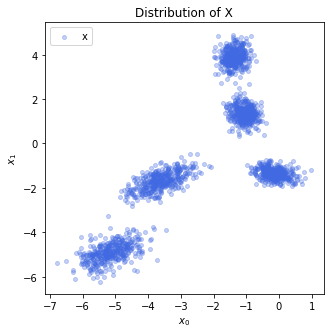

In [8]:
x = np.loadtxt("X.txt", delimiter=" ")

fig, ax = plt.subplots(figsize=(5, 5))
plot_distribution(ax, x)
fig.show()

## Train with data

In [9]:
y, mu, sigma, history = train(x, k=5)

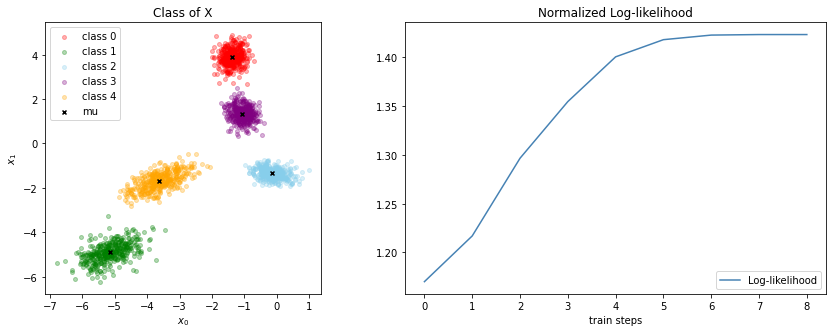

In [10]:
fig = plt.figure(figsize=(14, 5))
gs = fig.add_gridspec(1, 11)

ax0 = fig.add_subplot(gs[0, :4])
plot_distribution(ax0, x, y, mu)

ax1 = fig.add_subplot(gs[0, 5:])
plot_log_likelihood(ax1, history)

fig.show()